In [20]:
import os
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
import zarr
import allel; print('scikit-allel', allel.__version__)
# check which version is installed

#### Read VCF or zarr files

vcf_path = '/home/daron/bioInf/wilding/snpCalling/wilding_urbano.X.vcf.gz'
zarr_path = '/home/daron/bioInf/wilding/snpCalling/wilding_urbano.X.zarr'
if not os.path.isdir(zarr_path):
    allel.vcf_to_zarr(vcf_path, zarr_path, fields='*', overwrite=True)
callset = zarr.open_group(zarr_path, mode='r')

vcf_path = '/home/daron/bioInf/wilding/snpCalling/ag1000g.phase2.ar1.pass.X.GAgam.vcf.gz'
zarr_path = '/home/daron/bioInf/wilding/snpCalling/ag1000g.phase2.ar1.pass.X.GAgam.zarr'
if not os.path.isdir(zarr_path):
    allel.vcf_to_zarr(vcf_path, zarr_path, fields='*', overwrite=True)
callset_GAgam = zarr.open_group(zarr_path, mode='r')

vcf_path = '/home/daron/bioInf/wilding/snpCalling/accessibility.X.vcf.gz'
zarr_path = '/home/daron/bioInf/wilding/snpCalling/accessibility.X.zarr'
if not os.path.isdir(zarr_path):
    allel.vcf_to_zarr(vcf_path, zarr_path, fields='*', overwrite=True)
callset_access = zarr.open_group(zarr_path, mode='r')


scikit-allel 1.3.2


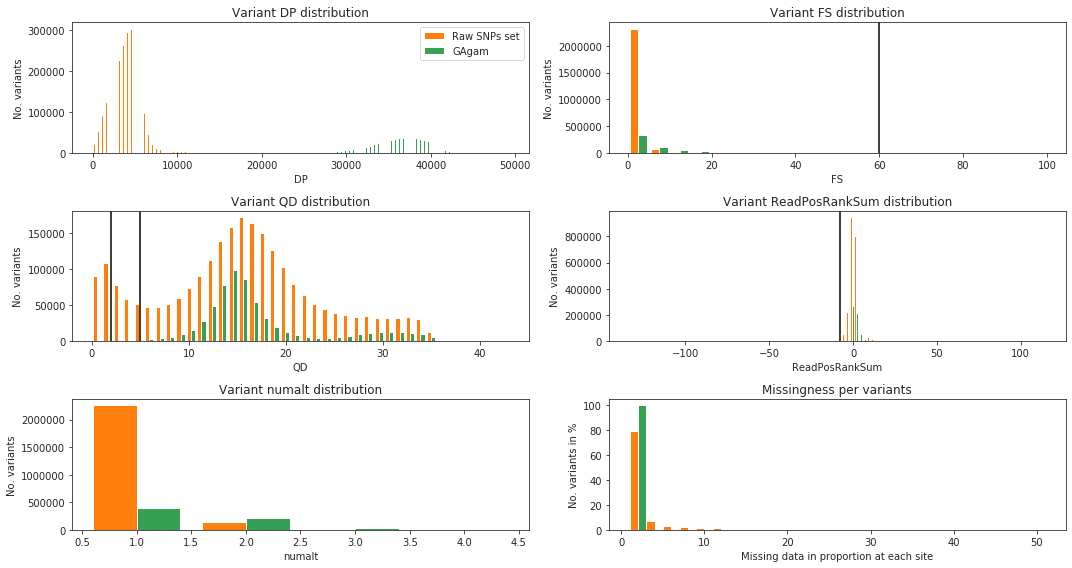

In [48]:
#### Visualize variant attributes
# https://gatk.broadinstitute.org/hc/en-us/articles/360035890471-Hard-filtering-germline-short-variants

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
#sns.despine(ax=ax, offset=10)

# DP
multi_x = (callset["variants/DP"], callset_GAgam["variants/DP"])
# ax0.hist(multi_x, bins=range(0, 4000 + 50, 50), color=['C0', 'C2'])
ax0.hist(multi_x, bins=100, color=['C1', '#38A055'], label=["Raw SNPs set", "GAgam"])
ax0.set_xlabel("DP")
ax0.set_ylabel('No. variants')
ax0.set_title('Variant DP distribution')
ax0.legend(loc='upper right')

# FS fisher strand
multi_x = (callset["variants/FS"], callset_GAgam["variants/FS"])
ax1.hist(multi_x, bins=range(0, 100 + 5, 5), color=['C1', '#38A055'])
ax1.set_xlabel("FS")
ax1.set_ylabel('No. variants')
ax1.set_title('Variant FS distribution')
ax1.axvline(x=60, c='black')

# QD qualbydepth
multi_x = (callset["variants/QD"], callset_GAgam["variants/QD"])
ax2.hist(multi_x, bins=40, color=['C1', '#38A055'])
ax2.set_xlabel("QD")
ax2.set_ylabel('No. variants')
ax2.set_title('Variant QD distribution')
ax2.axvline(x=2, c='black')
ax2.axvline(x=5, c='black')

# ReadPosRankSum
x = np.array(callset["variants/ReadPosRankSum"])
x_no_nan = x[~np.isnan(x)]
x = np.array(callset_GAgam["variants/ReadPosRankSum"])
x_GAgam_no_nan = x[~np.isnan(x)]
multi_x = (x_no_nan, x_GAgam_no_nan)
ax3.hist(multi_x, bins=100, color=['C1', '#38A055'])
ax3.set_xlabel("ReadPosRankSum")
ax3.set_ylabel('No. variants')
ax3.set_title('Variant ReadPosRankSum distribution')
ax3.axvline(x=-8, c='black')

# Number of alternative allele
multi_x = (callset["variants/numalt"], callset_GAgam["variants/numalt"])
ax4.hist(multi_x, bins=np.arange(0.5, 5.5, 1), color=['C1', '#38A055'])
ax4.set_xlabel("numalt")
ax4.set_ylabel('No. variants')
ax4.set_title('Variant numalt distribution')

# Distribution missing data
miss = np.count_nonzero(callset["calldata/GT"][:,:,0] == -1, axis=1)
miss_pct = (miss/callset["calldata/GT"].shape[1])*100
miss_hist, bin_edges = np.histogram(miss_pct, bins=range(0, 50 + 2, 2))
miss_hist = (miss_hist/miss_hist.sum())*100

miss_pass = np.count_nonzero(callset_GAgam["calldata/GT"][:,:,0] == -1, axis=1)
miss_pass_pct = (miss_pass/callset_GAgam["calldata/GT"].shape[1])*100
miss_pass_hist, bin_edges = np.histogram(miss_pass_pct, bins=range(0, 50 + 2, 2))
miss_pass_hist = (miss_pass_hist/miss_pass_hist.sum())*100

bar_width = 1
ax5.bar(bin_edges[range(1,len(miss_hist)+1)] - (bar_width/2), miss_hist, width=bar_width, color='C1')
ax5.bar(bin_edges[range(1,len(miss_hist)+1)] + (bar_width/2), miss_pass_hist, width=bar_width, color='#38A055')
ax5.set_xlabel("Missing data in proportion at each site")
ax5.set_ylabel('No. variants in %')
ax5.set_title('Missingness per variants')

plt.tight_layout()
plt.show()


/home/daron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


Number of SNP passing QD>2: 1309007
Number of SNP passing QD>5: 1275726


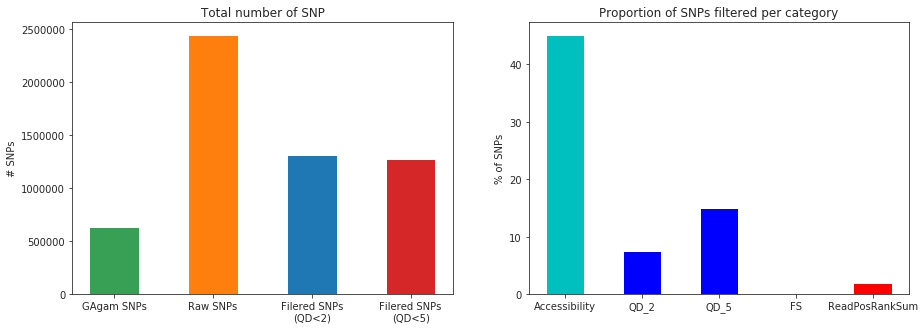

In [23]:
#### Filtration of variant
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#### Accessibility filtering

access = np.array(callset_access['variants/POS'])[np.array(callset_access['variants/Accessible'])]
intersection = np.intersect1d(access, np.array(callset['variants/POS']))
access_pct = 100-(len(intersection)/len(np.array(callset['variants/POS']))*100)
pass_snp_pos = intersection

#### hard filtering
## FS
array = np.array(callset['variants/FS'])
FS_pct = (len(array[array>60])/len(array))*100
pos_pass = np.array(callset['variants/POS'])[array<=60]
pass_snp_pos = np.intersect1d(pos_pass, pass_snp_pos)

## ReadPosRankSum
array = np.array(callset['variants/ReadPosRankSum'])
array_no_nan = array[~np.isnan(array)]
ReadPosRankSum_pct = (len(array_no_nan[array_no_nan<-8.000])/len(array_no_nan))*100
pos_pass = np.array(callset['variants/POS'])[array>=-8.000]
pass_snp_pos = np.intersect1d(pos_pass, pass_snp_pos)

## QD
array = np.array(callset['variants/QD'])
QD_pct_5 = (len(array[array<5])/len(array))*100
QD_pct_2 = (len(array[array<2])/len(array))*100

pos_pass = np.array(callset['variants/POS'])[array>=5]
pass_snp_pos_QD_5 = np.intersect1d(pos_pass, pass_snp_pos)

pos_pass = np.array(callset['variants/POS'])[array>=2]
pass_snp_pos_QD_2 = np.intersect1d(pos_pass, pass_snp_pos)

print("Number of SNP passing QD>2:", len(pass_snp_pos_QD_2))
print("Number of SNP passing QD>5:", len(pass_snp_pos_QD_5))

#### Plot 
bar_width = 0.5
y = [len(callset_GAgam['variants/POS']), len(callset['variants/POS']),len(pass_snp_pos_QD_2), len(pass_snp_pos_QD_5)]
x = ['GAgam SNPs', 'Raw SNPs', 'Filered SNPs\n(QD<2)', 'Filered SNPs\n(QD<5)']
ax0.bar(np.arange(len(x)), y, bar_width, color=['#38A055', 'C1', 'C0', 'C3'])
ax0.set_xticks(np.arange(len(x)))
ax0.set_xticklabels(x)
ax0.set_xlabel('')
ax0.set_ylabel('# SNPs')
ax0.set_title('Total number of SNP')

x = ['Accessibility', 'QD_2', 'QD_5', 'FS', 'ReadPosRankSum']
y = [access_pct, QD_pct_2, QD_pct_5, FS_pct, ReadPosRankSum_pct]
ax1.bar(np.arange(len(x)), y, bar_width, color=['c', 'b', 'b', 'y', 'r'])
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x)
ax1.set_xlabel('')
ax1.set_ylabel('% of SNPs')
ax1.set_title('Proportion of SNPs filtered per category')

plt.show()


Text(0.5, 1.0, 'variant density')

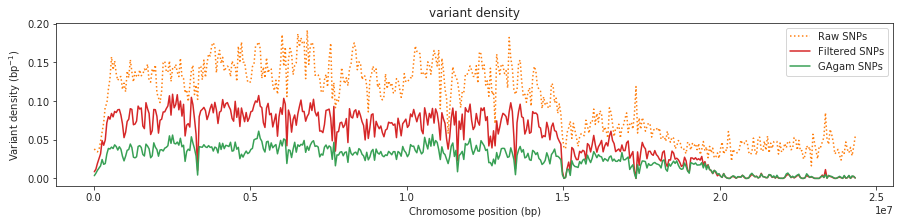

In [24]:
#### Visualize variant density
pos = callset['variants/POS']
pos_pass = pass_snp_pos_QD_5
pos_GAgam = callset_GAgam['variants/POS']

pos_max = 0
if max(pos) < max(pos_pass):
    pos_max = max(pos_pass)
else:
    pos_max = max(pos)

window_size = 50000
bins = np.arange(0, pos_max, window_size)

# use window midpoints as x coordinate
x = (bins[1:] + bins[:-1])/2

# compute variant density in each window
h, _ = np.histogram(pos, bins=bins)
y = h / window_size
h, _ = np.histogram(pos_pass, bins=bins)
y_pass = h / window_size
h, _ = np.histogram(pos_GAgam, bins=bins)
y_GAgam = h / window_size

# plot
fig, ax = plt.subplots(figsize=(15, 3))
# sns.despine(ax=ax, offset=10)
ax.plot(x, y, linestyle=":", label="Raw SNPs", color="C1")
ax.plot(x, y_pass, label="Filtered SNPs", color="C3")
ax.plot(x, y_GAgam, label="GAgam SNPs", color="#38A055")
ax.legend()
ax.set_xlabel('Chromosome position (bp)')
ax.set_ylabel('Variant density (bp$^{-1}$)')
ax.set_title('variant density')



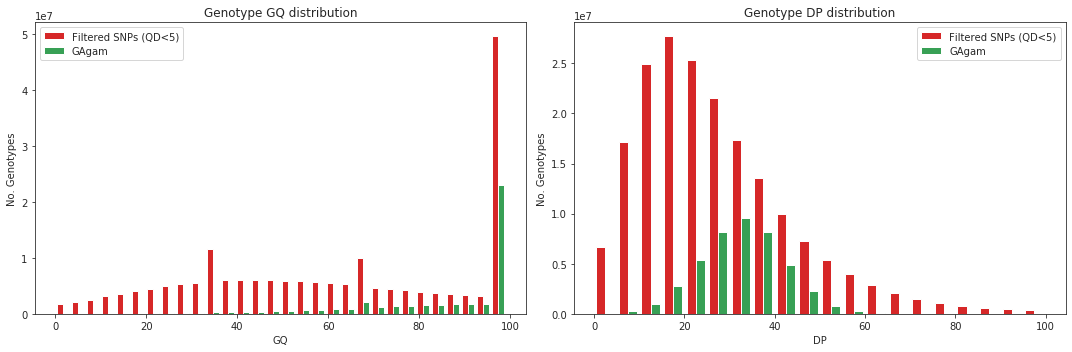

In [25]:
#### Visualize calldata attributes GQ and DP
pos = allel.SortedIndex(callset['variants/POS'])
index = np.in1d(pos, pass_snp_pos_QD_5).nonzero()[0]

loc_variant_selection, _ = pos.locate_intersection(pass_snp_pos_QD_5)
gt = allel.GenotypeArray(callset['calldata/GT'])
gt_variant_selection = gt.compress(loc_variant_selection, axis=0)

gq = np.array(callset["calldata/GQ"])
gq_variant_selection = gq[index]

dp = np.array(callset["calldata/DP"])
dp_variant_selection = dp[index]

# raise SystemExit("Stop right there!")

gt_GAgam_zarr = allel.GenotypeArray(callset_GAgam["calldata/GT"])
gq_GAgam = np.array(callset_GAgam["calldata/GQ"])
dp_GAgam = np.array(callset_GAgam["calldata/DP"])

#### plot
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# GQ
multi_x = (gq_variant_selection[~gt_variant_selection.is_missing()], gq_GAgam[~gt_GAgam_zarr.is_missing()])
ax0.hist(multi_x, bins=30, color=["C3", "#38A055"], label=["Filtered SNPs (QD<5)", "GAgam"])
ax0.set_xlabel("GQ")
ax0.set_ylabel('No. Genotypes')
ax0.set_title('Genotype GQ distribution')
ax0.legend()

# DP
multi_x = (dp_variant_selection[~gt_variant_selection.is_missing()], dp_GAgam[~gt_GAgam_zarr.is_missing()])

# ax1.hist(multi_x, bins=50)
ax1.hist(multi_x, bins=range(0, 100 + 5, 5), color=["C3", "#38A055"], label=["Filtered SNPs (QD<5)", "GAgam"])
ax1.set_xlabel("DP")
ax1.set_ylabel('No. Genotypes')
ax1.set_title('Genotype DP distribution')
ax1.legend()

plt.tight_layout()
plt.show()


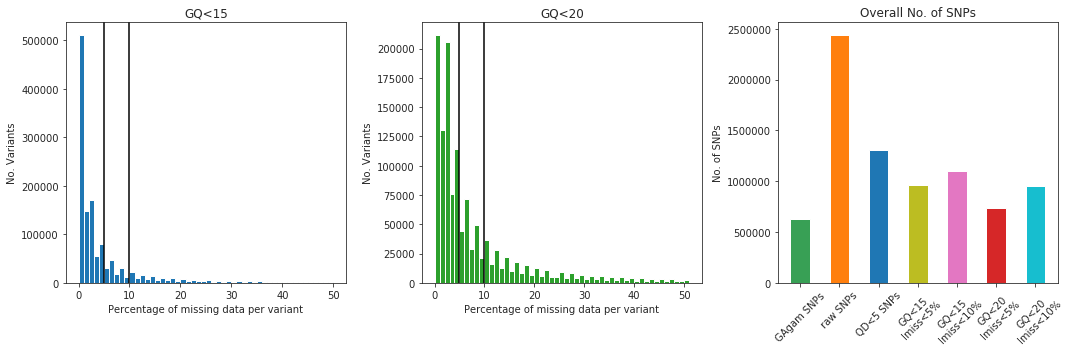

In [27]:
#### Visualize distribution of missing data per variants 
fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# GQ < 15
miss = np.count_nonzero(gq_variant_selection < 15, axis=1)
miss_pct = (miss/gq_variant_selection.shape[1])*100
lmiss_gq15_5 = (len(miss_pct[miss_pct<5]))
lmiss_gq15_10 = (len(miss_pct[miss_pct<10]))

ax0.hist(miss_pct, bins=range(0, 50 + 1, 1), color="C0")
ax0.set_xlabel("Percentage of missing data per variant")
ax0.set_ylabel('No. Variants')
ax0.set_title('GQ<15')
ax0.axvline(x=5, c='black')
ax0.axvline(x=10, c='black')

# GQ < 20
miss = np.count_nonzero(gq_variant_selection < 20, axis=1)
miss_pct = (miss/gq_variant_selection.shape[1])*100
lmiss_gq20_5 = (len(miss_pct[miss_pct<5]))
lmiss_gq20_10 = (len(miss_pct[miss_pct<10]))

ax1.hist(miss_pct, bins=range(0, 50 + 2, 1), color="C2")
ax1.set_xlabel("Percentage of missing data per variant")
ax1.set_ylabel('No. Variants')
ax1.set_title('GQ<20')
ax1.axvline(x=5, c='black')
ax1.axvline(x=10, c='black')

# print(len(miss_pct))
## Proportion of SNP removed 

y = [len(callset_GAgam['variants/POS']), len(callset['variants/POS']), gq_variant_selection.shape[0], lmiss_gq15_5, lmiss_gq15_10, lmiss_gq20_5, lmiss_gq20_10]
x = ['GAgam SNPs', 'raw SNPs', 'QD<5 SNPs', 'GQ<15\nlmiss<5%', 'GQ<15\nlmiss<10%', 'GQ<20\nlmiss<5%', 'GQ<20\nlmiss<10%']
ax2.bar(np.arange(len(x)), y, bar_width, color=['#38A055', 'C1', 'C0', 'C8', 'C6', 'C3', 'C9'])
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x, rotation=45)
ax2.set_xlabel('')
ax2.set_ylabel('No. of SNPs')
ax2.set_title('Overall No. of SNPs')

plt.tight_layout()
plt.show()

miss = np.count_nonzero(gq_variant_selection < 20, axis=1)
miss_pct = (miss/gq_variant_selection.shape[1])*100
gt_variant_selection_lmiss = gt_variant_selection[(miss_pct<5)]
gq_variant_selection_lmiss = gq_variant_selection[(miss_pct<5)]


In [28]:
print(gq_variant_selection_lmiss)

[[99 99 39 ... 36 51 72]
 [99 93 45 ... 48 78 84]
 [99 96 48 ... 48 78 84]
 ...
 [99 81 27 ... 33 36 96]
 [99 27 18 ... 51 57 69]
 [96 99 18 ... 54 57 66]]


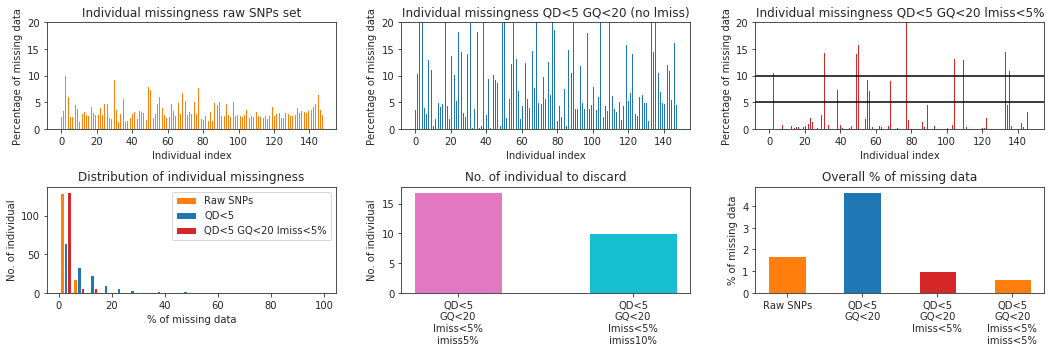

In [34]:
#### Filtering Individual based on proportion of missing data

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(15,5))

count_imiss_rawSNPs = np.count_nonzero(gt.is_missing() == True, axis=0)
pct_imiss_rawSNPs = (count_imiss_rawSNPs/gt.shape[0])*100
ax0.bar(range(0, len(pct_imiss_rawSNPs)), pct_imiss_rawSNPs, color="C1", width=1)
ax0.set_ylabel("Percentage of missing data")
ax0.set_xlabel('Individual index')
ax0.set_title('Individual missingness raw SNPs set')
ax0.set_ylim([0,20])

count_imiss_variant_selection = np.count_nonzero((gq_variant_selection < 20), axis=0) # count GQ bellow threshold
pct_imiss_variant_selection = (count_imiss_variant_selection/gt_variant_selection.shape[0])*100
ax1.bar(range(0, len(pct_imiss_variant_selection)), pct_imiss_variant_selection, color="C0", width=1)
ax1.set_ylabel("Percentage of missing data")
ax1.set_xlabel('Individual index')
ax1.set_title('Individual missingness QD<5 GQ<20 (no lmiss)')
ax1.set_ylim([0,20])

count_imiss_variant_selection_lmiss = np.count_nonzero((gq_variant_selection_lmiss < 20), axis=0) # count GQ bellow threshold
pct_imiss_variant_selection_lmiss = (count_imiss_variant_selection_lmiss/gq_variant_selection_lmiss.shape[0])*100
ax2.bar(range(0, len(pct_imiss_variant_selection_lmiss)), pct_imiss_variant_selection_lmiss, color="C3", width=1)
ax2.set_ylabel("Percentage of missing data")
ax2.set_xlabel('Individual index')
ax2.set_title('Individual missingness QD<5 GQ<20 lmiss<5%')
ax2.set_ylim([0,20])
ax2.axhline(y=5, c='black')
ax2.axhline(y=10, c='black')

#### distribution missigness individual
multi_x = (pct_imiss_rawSNPs, pct_imiss_variant_selection, pct_imiss_variant_selection_lmiss)
ax3.hist(multi_x, bins=range(0, 100 + 5, 5), color=["C1", "C0", "C3"], label=["Raw SNPs", "QD<5", "QD<5 GQ<20 lmiss<5%"])
ax3.set_xlabel("% of missing data")
ax3.set_ylabel('No. of individual')
ax3.legend()
ax3.set_title('Distribution of individual missingness')

## nb individual to keep 
x = ['QD<5\nGQ<20\nlmiss<5%\nimiss5%', 'QD<5\nGQ<20\nlmiss<5%\nimiss10%']
y = [gq_variant_selection_lmiss.shape[1]-len(pct_imiss_variant_selection_lmiss[pct_imiss_variant_selection_lmiss<5]),
     gq_variant_selection_lmiss.shape[1]-len(pct_imiss_variant_selection_lmiss[pct_imiss_variant_selection_lmiss<10])]
ax4.bar(np.arange(len(x)), y, bar_width, color=['C6', 'C9'])
ax4.set_xticks(np.arange(len(x)))
ax4.set_xticklabels(x, rotation=0)
ax4.set_xlabel('')
ax4.set_ylabel('No. of individual')
ax4.set_title('No. of individual to discard')

## Overall proportion of missing data
lmiss_thresold = 5
gq_variant_selection_lmiss_imiss = gq_variant_selection_lmiss[:,pct_imiss_variant_selection_lmiss < lmiss_thresold] 
# gt_variant_selection_lmiss_imiss = gt_variant_selection_lmiss[:,pct_imiss_variant_selection_lmiss < lmiss_thresold]

count_imiss_variant_selection_lmiss_imiss = np.count_nonzero(gq_variant_selection_lmiss_imiss < 20, axis=0)

y = [(count_imiss_rawSNPs.sum()/gt.size)*100,
     (count_imiss_variant_selection.sum()/gt_variant_selection.size)*100,
     (count_imiss_variant_selection_lmiss.sum()/gt_variant_selection_lmiss.size)*100,
     (count_imiss_variant_selection_lmiss_imiss.sum()/gq_variant_selection_lmiss_imiss.size)*100]

x = ['Raw SNPs', 'QD<5\nGQ<20', 'QD<5\nGQ<20\nlmiss<5%', 'QD<5\nGQ<20\nlmiss<5%\nimiss<5%']
bar_width = 0.5
ax5.bar(np.arange(len(x)), y, bar_width, color=['C1', 'C0', 'C3'])
ax5.set_xticks(np.arange(len(x)))
ax5.set_xticklabels(x)
ax5.set_xlabel('')
ax5.set_ylabel('% of missing data')
ax5.set_title('Overall % of missing data')

plt.tight_layout()
plt.show()


population  animal_sex
BZV         Female         6
            Male           3
DLA         Female        16
            Male          10
LBV         Female        22
            Male           8
LBVdom      Female        20
            Male          12
LPdom       Female        16
LPfor       Female        21
            Male           4
Name: id, dtype: int64


10 samples will be removed because imiss > 10%:
['BZV093bp' 'DLA136p' 'DLA137p' 'LBV066p' 'LBV072p' 'LBV131p' 'LP1124'
 'LP1145' 'LP47' 'LP63']


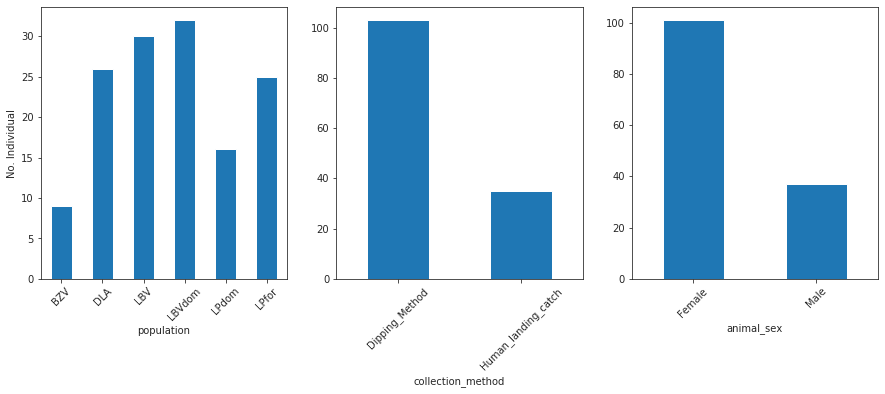

In [31]:
samples_fn = '/home/daron/bioInf/wilding/snpCalling/wilding_urbano.samples.meta.txt'
samplesInfo = pd.read_csv(samples_fn, encoding='utf-8-sig', sep='\t')
#samplesInfo.groupby(["location", "site"]).count()

keepSamples = callset["/samples"][:][pct_imiss_variant_selection_lmiss < 10]
index = np.in1d(np.array(samplesInfo.id), keepSamples).nonzero()[0]
samplesInfoSub = samplesInfo.iloc[index,:]

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
samplesInfoSub.groupby(["population"]).count()['id'].plot.bar(ax=ax0, rot=45)
ax0.set_ylabel("No. Individual")
samplesInfoSub.groupby(["collection_method"]).count()['id'].plot.bar(ax=ax1, rot=45)
samplesInfoSub.groupby(["animal_sex"]).count()['id'].plot.bar(ax=ax2, rot=45)

# print(samplesInfoSub.groupby(["population"]).count()['id'])

print(samplesInfoSub.groupby(["population", "animal_sex"]).count()['id'])
print("\n")
nb = len(callset["/samples"][:][pct_imiss_variant_selection_lmiss > 10])
print(f"{nb} samples will be removed because imiss > 10%:")
print(callset["/samples"][:][pct_imiss_variant_selection_lmiss > 10])




In [14]:
samplesInfo.groupby(["population"]).count()['id']

population
LBVdom    32
LPdom     32
LPfor     32
Name: id, dtype: int64

In [10]:
!jupyter nbconvert --to html /home/daron/bioInf/wilding/snpCalling/vcfStats.ipynb


[NbConvertApp] Converting notebook /home/daron/bioInf/wilding/snpCalling/vcfStats.ipynb to html
[NbConvertApp] Writing 760983 bytes to /home/daron/bioInf/wilding/snpCalling/vcfStats.html
